단기 푸리에 변환(STFT)를 소개하고, 이와 관련된 윈도우(window), 스펙트로그램(spectrogram), 패딩(padding) 전략 등을 살펴본다.

> 이 글은 [FMP(Fundamentals of Music Processing) Notebooks](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C0/C0.html)을 참고로 합니다.

In [2]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import librosa
import librosa.display
import scipy
import IPython.display as ipd
from IPython.display import Image

# 이산(Discrete) 단기 푸리에 변환 (Short-Time Fourier Transform, STFT)

## "Missing Time Localization"

- 기존 푸리에 변환은 전체 시간 영역에서 평균화되는 주파수 정보를 생성한다. 그러나 이러한 주파수가 **언제** 벌생하는지에 대한 정보는 변환에 숨겨져 있다. 이 현상은 다음 그림을 보면 알 수 있다.

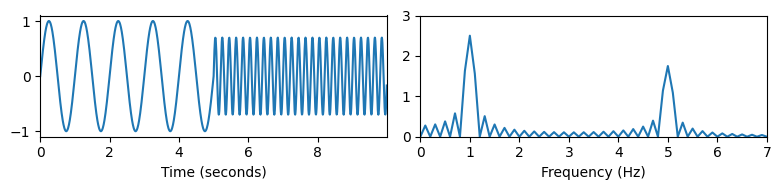

In [3]:
Fs = 128
duration = 10
omega1 = 1
omega2 = 5
N = int(duration * Fs)
t = np.arange(N) / Fs
t1 = t[:N//2]
t2 = t[N//2:]

x1 = 1.0 * np.sin(2 * np.pi * omega1 * t1)
x2 = 0.7 * np.sin(2 * np.pi * omega2 * t2)
x = np.concatenate((x1, x2))

plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
plt.plot(t, x)
plt.xlim([min(t), max(t)])
plt.xlabel('Time (seconds)')

plt.subplot(1, 2, 2)
X = np.abs(np.fft.fft(x)) / Fs
freq = np.fft.fftfreq(N, d=1/Fs)
X = X[:N//2]
freq = freq[:N//2]
plt.plot(freq, X)
plt.xlim([0, 7])
plt.ylim([0, 3])
plt.xlabel('Frequency (Hz)')
plt.tight_layout()

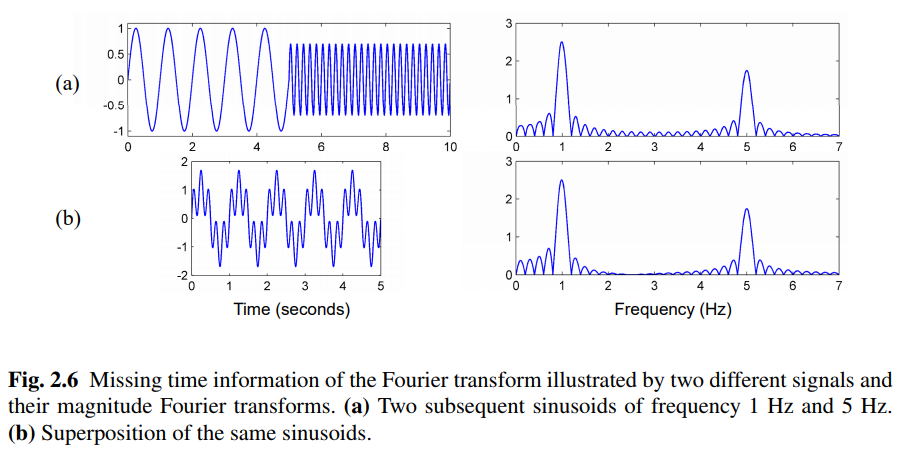

In [4]:
Image("../img/3.fourier_analysis/f.2.6.PNG", width=600)

## 기본 개념
- 숨겨진 시간 정보를 복구하기 위해 Dennis Gabor는 1946년에 **단시간 푸리에 변환**(STFT)을 도입했다. 
- 전체 신호를 고려하는 대신 STFT는 신호의 작은 부분만 고려한다. 이를 위해 짧은 시간 동안의 non-zero 함수, 소위 **윈도우 함수**(**window function**)를 고정한다. 그런 다음 원래 신호에 윈도우 함수를 곱하여 **윈도우(windowed) 신호**를 생성한다. 
- 서로 다른 시간 인스턴스에서 주파수 정보를 얻으려면 시간에 따라 윈도우 함수를 이동하고, 각 결과 윈도우 신호에 대해 푸리에 변환을 계산해야 한다. 

서로다른 window 변화에 대한 실험:


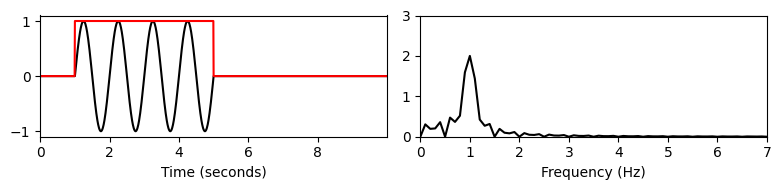

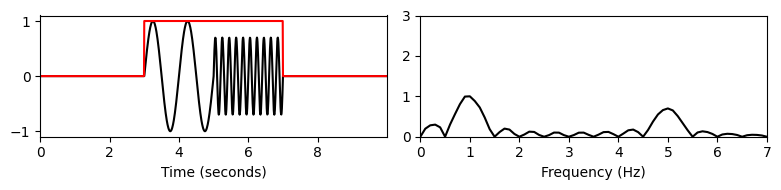

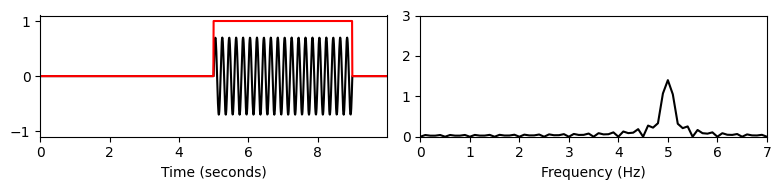

In [5]:
def windowed_ft(t, x, Fs, w_pos_sec, w_len):
    N = len(x)
    w_pos = int(Fs * w_pos_sec)
    w_padded = np.zeros(N)
    w_padded[w_pos:w_pos + w_len] = 1
    x = x * w_padded
    
    X = np.abs(np.fft.fft(x)) / Fs
    freq = np.fft.fftfreq(N, d=1/Fs)
    X = X[:N//2]
    freq = freq[:N//2]
    
    plt.figure(figsize=(8, 2))
    
    plt.subplot(1, 2, 1)
    plt.plot(t, x, c='k')
    plt.plot(t, w_padded, c='r')
    plt.xlim([min(t), max(t)])
    plt.ylim([-1.1, 1.1])
    plt.xlabel('Time (seconds)')
    
    plt.subplot(1, 2, 2)
    plt.plot(freq, X, c='k')
    plt.xlim([0, 7])
    plt.ylim([0, 3])
    plt.xlabel('Frequency (Hz)')
    plt.tight_layout()
    
print('서로다른 window 변화에 대한 실험:')

w_len = 4 * Fs
windowed_ft(t, x, Fs, w_pos_sec=1, w_len=w_len) # 윈도우 신호 t=1 중심
windowed_ft(t, x, Fs, w_pos_sec=3, w_len=w_len) # t=3
windowed_ft(t, x, Fs, w_pos_sec=5, w_len=w_len) # t=5
plt.show()

## 윈도우(window)

- STFT는 원래 신호의 속성뿐만 아니라 윈도우 함수의 속성도 반영한다는 점에 유의해야 한다. 

- 우선 STFT는 섹션의 크기를 결정하는 **윈도우의 길이**에 따라 달라진다. 그리고 STFT는 **윈도우 모양**의 영향을 받는다. 예를 들어 직사각형 윈도우를 사용하면 일반적으로 단면 경계에서 불연속성이 발생하기 때문에 큰 단점이 있다. 이러한 급격한 변화는 전체 주파수 스펙트럼에 걸쳐 전파되는 간섭으로 인해 부작용을 발생시킨다: ripple artifacts.

**윈도우 유형**

- 이러한 경계 효과를 줄이기 위해 원하는 섹션 내에서 섹션의 경계를 향해 연속적으로 0으로 떨어지는 음이 아닌 윈도우를 사용한다. 그러한 예 중 하나는 훨씬 더 작은 ripple artifact를 초래하는 **삼각형 윈도우(triangular winow)** 이다. 

- 신호 처리에 자주 사용되는 윈도우는 **Hann 윈도우**(기상학자 Julius von Hann의 이름을 따서 명명됨, 1839~1921)이다. Hann 윈도우는 상승하는 코사인 윈도우로, 섹션 경계에서 스무스(smoothly)하게 0으로 떨어진다. 이는 윈도우 신호의 푸리에 변환에서 부작용을 완화한다. 그러나 단점은 Hann 윈도우가 약간의 주파수 번짐을 유발한다는 것이다. 

- 결과적으로 신호의 윈도우 영역의 푸리에 변환은 신호의 속성이 제안하는 것보다 더 스무스해 보일 수 있다. 즉, ripple artifact의 감소는 더 안좋은 spectral localization을 통해 달성된다 (trade-off 관계).

In [6]:
def windowed_ft2(t, x, Fs, w_pos_sec, w_len, w_type, upper_y=1.0):
    
    N = len(x)
    w_pos = int(Fs * w_pos_sec)
    w = np.zeros(N)
    w[w_pos:w_pos + w_len] = scipy.signal.get_window(w_type, w_len)
    x = x * w
    
    plt.figure(figsize=(8, 2))

    plt.subplot(1, 2, 1)
    plt.plot(t, x, c='k')
    plt.plot(t, w, c='r')
    plt.xlim([min(t), max(t)])
    plt.ylim([-1.1, 1.1])
    plt.xlabel('Time (seconds)')

    plt.subplot(1, 2, 2)
    X = np.abs(np.fft.fft(x)) / N * 2
    freq = np.fft.fftfreq(N, d=1/Fs)
    X = X[:N//2]
    freq = freq[:N//2]
    plt.plot(freq, X, c='k')
    plt.xlim([0, 50])
    plt.ylim([0, upper_y])
    plt.xlabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()

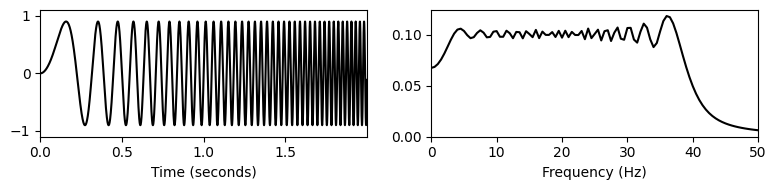

In [7]:
duration = 2.0
Fs = 2000
omega = 10
N = int(duration * Fs)
t = np.arange(N) / Fs
x = 0.9 * np.sin(2 * np.pi * omega * t * t)

plt.figure(figsize=(8, 2))

plt.subplot(1, 2, 1)
plt.plot(t, x, c='k')
plt.xlim([t[0], t[-1]])
plt.ylim([-1.1, 1.1])
plt.xlabel('Time (seconds)')

plt.subplot(1, 2, 2)
X = np.abs(np.fft.fft(x)) / N * 2
freq = np.fft.fftfreq(N, d=1/Fs)
X = X[:N//2]
freq = freq[:N//2]
plt.plot(freq, X, c='k')
plt.xlim([0, 50])
plt.ylim(bottom=0)
plt.xlabel('Frequency (Hz)');
plt.tight_layout()

Rectangular window:


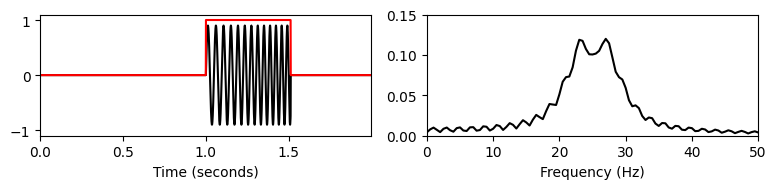

Triangular window:


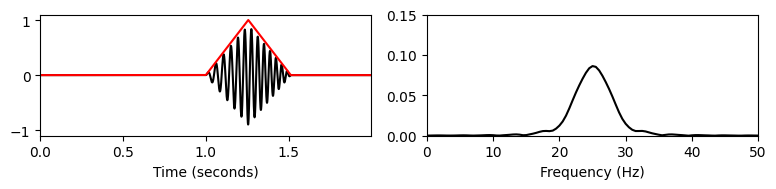

Hann window:


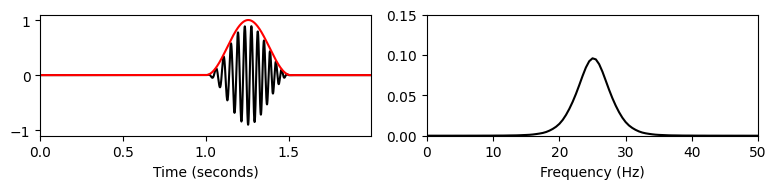

In [8]:
w_len = 1024
w_pos = 1280
print('Rectangular window:')
windowed_ft2(t, x, Fs, 1.0, w_len, 'boxcar', upper_y=0.15)
print('Triangular window:')
windowed_ft2(t, x, Fs, 1.0, w_len, 'triang', upper_y=0.15)
print('Hann window:')
windowed_ft2(t, x, Fs, 1.0, w_len, 'hann', upper_y=0.15)

## Discrete-STFT의 정의

- 이제 STFT의 이산적 사례를 고려하고 실제 적용에 필요한 가장 중요한 수학 공식을 구체화해보자.

- $x:[0:L-1]:=\{0,1,\ldots,L-1\}\to{\mathbb R}$가 길이 $L$의 실수 값 이산 시간(DT) 신호라고 가정하자. 이는 헤르츠(Hertz)로 주어진 고정 샘플링 비율 $F_\mathrm{s}$에 대해 등거리(equidistant) 샘플링에 의해 얻어진다. 

- $w:[0:N-1]\to\mathbb{R}$를 길이 $N\in\mathbb{N}$의 표본 윈도우 함수라고 하자. 예를 들어 직사각형 윈도우의 경우  $w(n)=1$ for $n\in[0:N-1]$이다. 길이 파라미터 $N$는 해당 섹션의 기간을 결정하며 이는 $N/F_\mathrm{s}$초에 해당된다. 

- **홉 크기**(**hop size**)라고 하는 추가 파라미터 $H\in\mathbb{N}$를 도입한다. 홉 크기 파라미터는 샘플에 지정되며 신호에서 윈도우가 이동하는 단계 크기(step size)를 결정한다. 이러한 파라미터와 관련하여 신호 $x$의 **이산 STFT** $\mathcal{X}$는 다음과 같다.
$$ \mathcal{X}(m,k):= \sum_{n=0}^{N-1} x(n+mH)w(n)\mathrm{exp}(-2\pi ikn/N) $$
with $m\in[0:M]$ and $k\in[0:K]$

- $M:=\lfloor \frac{L-N}{H} \rfloor$는 윈도우 시간 범위가 신호의 시간 범위에 완전히 포함되도록 하는 최대 프레임 인덱스(maximal frame index)이다(나중에 패딩(padding) 전략을 사용하는 일부 변형을 볼 것).

- 또한 $K=N/2$($N$이 짝수라고 가정)는 Nyquist 주파수에 해당하는 주파수 인덱스이다. 

- 복소수 $ \mathcal{X}(m,k)$는 $m^{\mathrm{th}}$ 시간 프레임에 대한 $k^{\mathrm{th}}$ 푸리에 계수를 나타낸다. 

- 각 고정 시간 프레임 $m$에 대해, 0에 대한 계수 $\mathcal{X}(m,k)$ for $k\in[0:K]$에 의해 주어진 크기 $K+1$의 **스펙트럼 벡터(spectral vector)** 를 얻는다.

- 이러한 각 스펙트럼 벡터의 계산은 $N$ 크기의 DFT에 해당하며 FFT를 사용하여 효율적으로 수행될 수 있다.

# 스펙트로그램 (Spectrogram)

- **스펙트로그램**은 STFT의 제곱 크기를 2차원으로 표현한 것이다.

\begin{eqnarray}
    \mathcal{Y}(m,k):= | \mathcal{X}(m,k)|^2.
\end{eqnarray} 

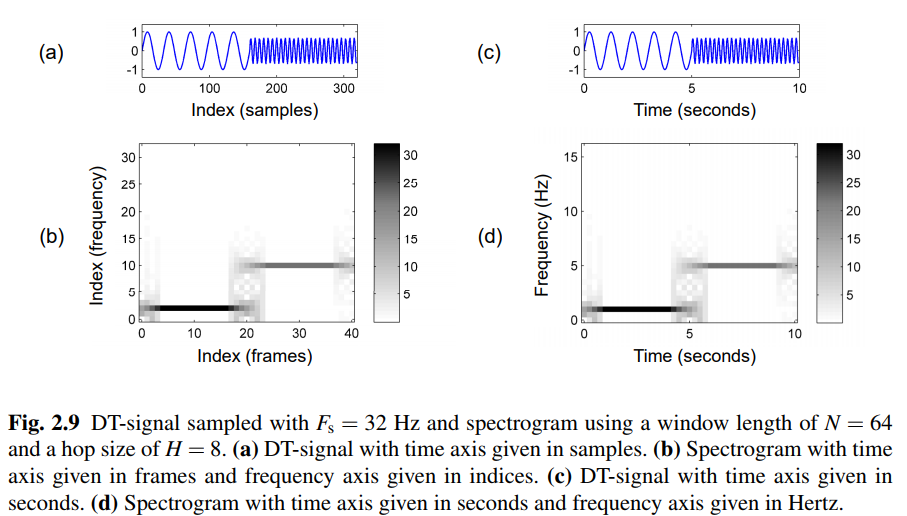

In [9]:
Image("../img/3.fourier_analysis/f.2.9.PNG", width=600)

- 수평축은 시간을 나타내고 수직축은 주파수를 나타내는 2차원 이미지를 통해 시각화할 수 있다. 이 이미지에서 스펙트로그램 값 $\mathcal{Y}(m,k)$는 좌표 $(m,k)$에서 이미지 색상 또는 강도로 표시된다. 단, 이산형의 경우 시간축은 프레임 인덱스 $m$로, 주파수 축은 주파수 인덱스 $k$로 지수화된다.

In [10]:
def stft_basic(x, w, H=8, only_positive_frequencies=False):
    """Compute a basic version of the discrete short-time Fourier transform (STFT)

    Args:
        x (np.ndarray): Signal to be transformed
        w (np.ndarray): Window function
        H (int): Hopsize (Default value = 8)
        only_positive_frequencies (bool): Return only positive frequency part of spectrum (non-invertible)
            (Default value = False)

    Returns:
        X (np.ndarray): The discrete short-time Fourier transform
    """
    N = len(w)
    L = len(x)
    M = np.floor((L - N) / H).astype(int) + 1
    X = np.zeros((N, M), dtype='complex')
    for m in range(M):
        x_win = x[m * H:m * H + N] * w
        X_win = np.fft.fft(x_win)
        X[:, m] = X_win

    if only_positive_frequencies:
        K = 1 + N // 2
        X = X[0:K, :]
    return X

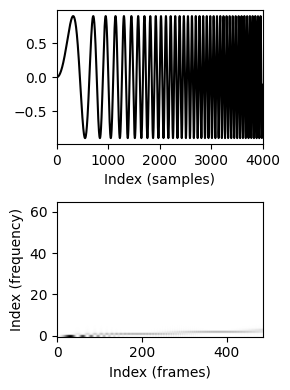

In [11]:
H = 8
N = 128
w = np.ones(N)
X = stft_basic(x, w, H, only_positive_frequencies=True)
Y = np.abs(X) ** 2

plt.figure(figsize=(3, 4))
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(t)), x, c='k')
plt.xlim([0, len(t)])
plt.xlabel('Index (samples)')
plt.subplot(2, 1, 2)
plt.imshow(Y, origin='lower', aspect='auto', cmap='gray_r')
plt.xlabel('Index (frames)')
plt.ylabel('Index (frequency)')
plt.tight_layout()

### 윈도우 유형에 따른 스펙트로그램 차이

- 예시의 chirp 신호:
    - $f(t)=\sin(400\pi t^2) \mathrm{\quad for \quad } t\in[0,1],$

- $t=1$을 향해 페이드 아웃된다. 이 처프의 경우 순간 주파수는 $t=0$에서 $\omega = 0~\mathrm{Hz}$에서 $t=1$에서 $\omega = 400~\mathrm{Hz}$로 선형적으로 증가한다.

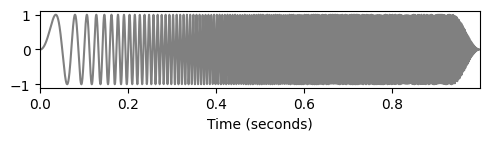

In [12]:
# chirp signal 생성
duration = 1.0
Fs = 4000
N = int(duration * Fs)
t = np.arange(0, N) / Fs
x = np.sin(np.pi * 400 * t * t)

size_fade = 256
w_fade = np.hanning(size_fade * 2)[size_fade:]
x[-size_fade:] *= w_fade

ipd.display(ipd.Audio(x, rate=Fs))

plt.figure(figsize=(5, 1.5))
plt.plot(t, x, c='gray')
plt.xlabel('Time (seconds)')
plt.xlim( [t[0], t[-1]] );
plt.tight_layout()

- STFT를 계산하기 위해 $62.5$msec 크기의 직사각형 윈도우과 Hann 윈도우를 사용하자. 
- 스펙트로그램의 이미지는 처프 신호의 선형 주파수 증가를 나타내는 강한 대각선 줄무늬를 보여준다. 
- 윈도우는 푸리에 영역에서 약간의 주파수 번짐과 추가적 부산물을 만든다. 이는 강한 대각선 위아래로 있는 약한 대각선 줄무늬르 보면 알 수 있다. 이러한 약한 줄무늬는 윈도우 함수의 푸리에 변환에서 발생하는 ripple(잔물결)에 해당한다.
- Hann 윈도우 대신 직사각형 윈도우을 사용할 때 ripple artifacts가 더 강하다는 것을 관찰할 수 있다. 
- 일반적으로는 신호의 특성과 윈도우 함수에 의해 초래하는 효과를 구분하기는 쉽지 않다.

In [13]:
w_len_ms = 62.5
N = int((w_len_ms / 1000) * Fs)
H = 4
X_hann = librosa.stft(x, n_fft=N*16, hop_length=H, win_length=N, window='hann', center=True, pad_mode='constant') # Hann
X_rect = librosa.stft(x, n_fft=N*16, hop_length=H, win_length=N, window='boxcar', center=True, pad_mode='constant') # 직사각형

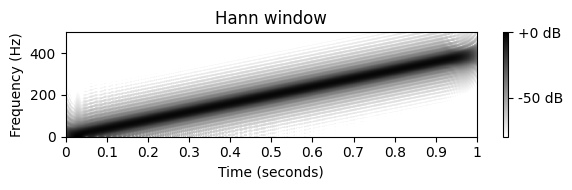

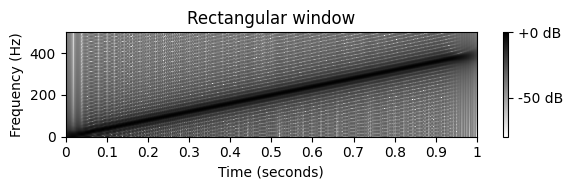

In [14]:
plt.figure(figsize=(6, 2))
librosa.display.specshow(librosa.amplitude_to_db( np.abs(X_hann), ref=np.max), 
                         y_axis='linear', x_axis='time', sr=Fs, hop_length=H, cmap='gray_r')
plt.clim([-80, 0])
plt.ylim([0, 500])
plt.xlim([0, 1])
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.title('Hann window')
plt.tight_layout()

plt.figure(figsize=(6, 2))
librosa.display.specshow(librosa.amplitude_to_db( np.abs(X_rect), ref=np.max), 
                         y_axis='linear', x_axis='time', sr=Fs, hop_length=H, cmap='gray_r')
plt.clim([-80, 0])
plt.ylim([0, 500])
plt.xlim([0, 1])
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.title('Rectangular window')
plt.tight_layout()

### 윈도우 크기에 따른 스펙트로그램 차이

- 예시의 신호:
    - $f(t)=\sin (800\pi t)+\sin (900\pi t) + \delta(t-0.45) + \delta(t-0.5) \mathrm{\quad for \quad } t\in[0,1]$
    
- $f$는 각각 주파수 $400$ 및 $450~\mathrm{Hz}$의 두 정현파의 중첩(superposition)이다. 또한 $t=0.45$ 및 $t=0.5$ 초에 두 개의 임펄스(impulse)가 추가된다. $f$는 표시된 구간 $[0,1]$ 밖에서는 0이라고 가정한다.

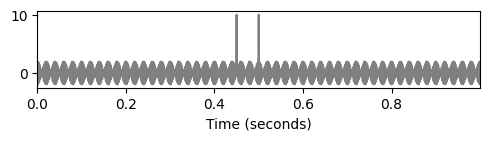

In [15]:
# 신호 생성
duration = 1.0
Fs = 4000
N = int(duration * Fs)
t = np.arange(N) / Fs
x = np.sin(2 * np.pi * 400 * t) + np.sin(2 * np.pi * 450 * t)
x[int(round(0.45 * Fs))] = 10
x[int(round(0.50 * Fs))] = 10

ipd.display(ipd.Audio(x, rate=Fs))

plt.figure(figsize=(5, 1.5))
plt.plot(t, x, c='gray')
plt.xlabel('Time (seconds)')
plt.xlim( [t[0], t[-1]] )
plt.tight_layout()

- 스펙트로그램을 계산하기 위해 다양한 크기의 Hann 윈도우를 사용해보자. 
- $32$ msec의 크기를 사용하여 스펙트로그램에서 정현파에 해당하는 $375$와 $475~\mathrm{Hz}$ 사이의 영역에서 가로 줄무늬를 관찰할 수 있고, 임펄스(impulses)에 해당하는 $t=0.45$와 $t=0.5~\sec$에서의 두 수직 줄무늬를 관찰할 수 있다. 
- 두 개의 임펄스가 명확하게 분리될 수 있지만(각 $32$ msec 윈도우에는 최대 하나의 임펄스가 있음), $\omega=400~\mathrm{Hz}$ 및 $\omega=450 ~\mathrm{Hz}$에서의 두 주파수 구성요소는 잘 분리되지 않는다(선택한 윈도우에 의해 도입된 주파수 번짐으로 인해).
- 윈도우 크기를 늘리면 상황이 달라진다. 예를 들어 $128$ msec 크기의 Hann 윈도우를 사용하면 2개의 가로 줄무늬로 표시된 것처럼 2개의 주파수 구성 요소가 명확하게 분리된다. 그러나 윈도우 크기를 늘리면 시간 영역에서 번짐이 증가한다. 결과적으로 두 임펄스가 더 이상 분리되지 않는다. 
- 여담으로 $t=0$ 및 $t=1$에 표시되는 두 개의 세로 줄무늬를 보면 이는 표시된 시간 간격을 벗어난 제로 패딩(zero-padding)의 결과이다.

In [16]:
w_len_ms = 32
N = int((w_len_ms / 1000) * Fs)
H = 16
X_short = librosa.stft(x, n_fft=N*16, hop_length=H, win_length=N, window='hann', center=True, pad_mode='constant')

w_len_ms = 128
N = int((w_len_ms / 1000) * Fs)
H = 16
X_long = librosa.stft(x, n_fft=N*16, hop_length=H, win_length=N, window='hann', center=True, pad_mode='constant')

C:\Users\JHCho\anaconda3\envs\mir\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=8192 is too small for input signal of length=4000
  return f(*args, **kwargs)


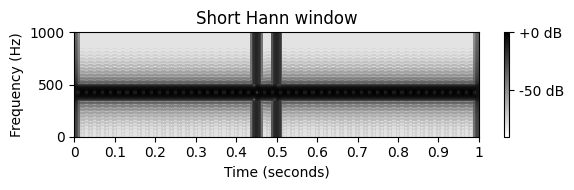

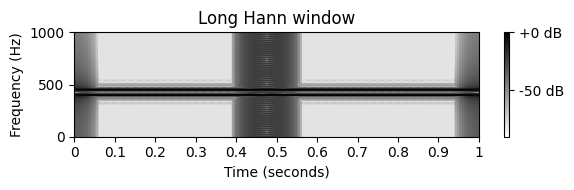

In [17]:
plt.figure(figsize=(6,2))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(X_short), ref=np.max), 
                         y_axis='linear', x_axis='time', sr=Fs, hop_length=H, cmap='gray_r')
plt.clim([-90, 0])
plt.ylim([0, 1000])
plt.xlim([0, 1])
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.title('Short Hann window')
plt.tight_layout()

plt.figure(figsize=(6,2))
librosa.display.specshow(librosa.amplitude_to_db( np.abs(X_long), ref=np.max), 
                         y_axis='linear', x_axis='time', sr=Fs, hop_length=H, cmap='gray_r')
plt.clim([-90, 0])
plt.ylim([0, 1000])
plt.xlim([0, 1])
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.title('Long Hann window')
plt.tight_layout()

## 시간 및 주파수 인덱스에 대한 해석

- 시간 차원의 경우, 각 푸리에 계수 $\mathcal{X}(m,k)$는 초 단위로 주어진 물리적 시간 위치와 연관된다.
\begin{equation}
         T_\mathrm{coef}(m) := \frac{m\cdot H}{F_\mathrm{s}}
\end{equation}

- 예를 들어 가능한 가장 작은 홉 크기 $H=1$의 경우 $T_\mathrm{coef}(m)=m/F_\mathrm{s}=m\cdot T~\sec$를 얻는다. 이 경우 DT 신호 $x$의 각 샘플에 대한 스펙트럼 벡터를 얻으므로 데이터 양이 크게 증가한다.

- 또한, 하나의 샘플에 의해서만 이동된 섹션을 고려하면 일반적으로 매우 유사한 스펙트럼 벡터가 생성된다. 이러한 유형의 중복성을 줄이기 위해 일반적으로 홉 크기를 윈도우 길이 $N$에 연관시킨다. 예를 들어, $H=N/2$를 선택하는 경우가 많으며, 이는 생성된 모든 스펙트럼 계수를 포함하는 데이터 크기와 합리적인 시간의 분해 사이의 좋은 trade-off이다. 

- 주파수 차원의 경우 $\mathcal{X}(m,k)$의 인덱스 $k$는 물리적 주파수에 해당된다.

\begin{equation}
         F_\mathrm{coef}(k) := \frac{k\cdot F_\mathrm{s}}{N} 
\end{equation}

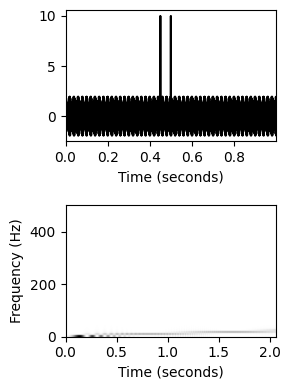

In [18]:
T_coef = np.arange(X.shape[1]) * H / Fs
F_coef = np.arange(X.shape[0]) * Fs / N

plt.figure(figsize=(3, 4))

plt.subplot(2, 1, 1)
plt.plot(t, x, c='k')
plt.xlim([min(t), max(t)])
plt.xlabel('Time (seconds)')

plt.subplot(2, 1, 2)
left = min(T_coef)
right = max(T_coef) + N / Fs
lower = min(F_coef)
upper = max(F_coef)
plt.imshow(Y, origin='lower', aspect='auto', cmap='gray_r', 
           extent=[left, right, lower, upper])
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()

# 패딩 전략(padding strategy)

- 윈도우 크기 $N\in\mathbb{N}$로 STFT를 사용할 때 패딩의 두 가지 측면을 고려할 수 있다.

1. 첫 번째 윈도우의 중심은 신호의 샘플 인덱스 $N/2$에 해당한다. 하지만 $0$의 시간에 해당하는 첫 번째 윈도우을 생각하는 것이 편하다. 이를 달성하기 위해 신호 시작 부분에서 $N/2$ 샘플을 채울 수 있다.

2. 마지막 윈도우의 시간 범위는 신호의 시간 범위에 완전히 포함된다. 따라서 신호의 끝 부분은 신호의 나머지 부분만큼 많은 겹치는 윈도우로 덮이지 않는다. 이에 대응하기 위해 신호 끝에 패딩을 사용할 수 있다. 필요한 패딩의 정확한 양은 홉 크기와 창 크기에 따라 다르다. 그러나 실용적인 이유로 $N/2$의 패딩 길이를 다시 사용하는 경우가 많다.

- 패딩 전략 중 하나는 신호를 0으로 확장하는 것이다(**제로 패딩**). 다른 전략은 각각 첫 번째 샘플과 마지막 샘플의 신호를 미러링하여 샘플로 신호를 확장하는 것이다(**반사 패딩**). 여러 패딩 전략은 [`numpy.pad`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.pad.html) 문서에 설명되어 있다.

No padding:


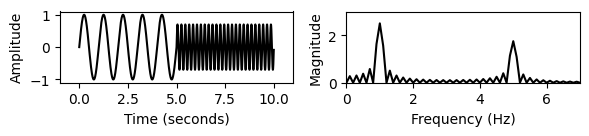

Zero padding:


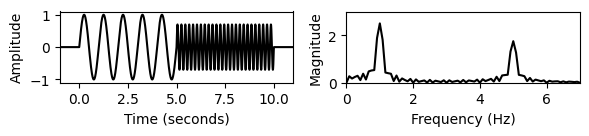

Reflect padding:


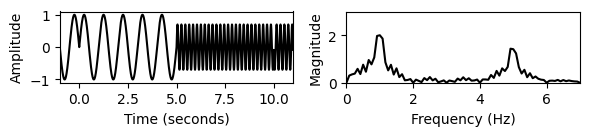

In [19]:
Fs = 256
duration = 10
omega1 = 1
omega2 = 5
N = int(duration * Fs)
t = np.arange(N) / Fs
t1 = t[:N//2]
t2 = t[N//2:]

x1 = 1.0 * np.sin(2 * np.pi * omega1 * t1)
x2 = 0.7 * np.sin(2 * np.pi * omega2 * t2)
x = np.concatenate((x1, x2))

def pad_and_plot(t, x, Fs, pad_len_sec, pad_mode):
    
    pad_len = int(pad_len_sec * Fs)
    
    t = np.concatenate((np.arange(-pad_len, 0) / Fs, t, 
                        np.arange(len(x), len(x) + pad_len) / Fs))
    x = np.pad(x, pad_len, pad_mode)
    N = len(x)
        
    plt.figure(figsize=(6, 1.5))
    ax1 = plt.subplot(1, 2, 1)
    plt.plot(t, x, c='k')
    #plt.xlim([t[0], t[-1]])
    plt.xlim([-1.0, 11.0])
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')

    ax2 = plt.subplot(1, 2, 2)
    X = np.abs(np.fft.fft(x)) / Fs
    freq = np.fft.fftfreq(N, d=1/Fs)
    X = X[:N//2]
    freq = freq[:N//2]
    plt.plot(freq, X, c='k')
    plt.xlim([0, 7])
    plt.ylim([0, 3])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.tight_layout()
    plt.show()
    
    return ax1, ax2
    
print('No padding:')
ax1, ax2 = pad_and_plot(t, x, Fs, 0.0, 'constant')

print('Zero padding:')
ax1, ax2 = pad_and_plot(t, x, Fs, 1.0, 'constant')

print('Reflect padding:');
ax1, ax2 = pad_and_plot(t, x, Fs, 1.0, 'reflect')

- 서로 다른 패딩 전략을 사용하면 해당 스펙트로그램의 시작과 끝이 달라진다. $N/2$보다 작은 홉(hop) 크기를 사용하는 경우 시작과 끝 모두에서 둘 이상의 프레임이 영향을 받는다. 
- 다음 그림은 **에지 현상 (edge phenomena)** 을 보여준다.

In [20]:
def compute_stft(x, Fs, N, H, pad_mode='constant', center=True, color='gray_r'):    
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, 
                     window='hann', pad_mode=pad_mode, center=center)
    Y = np.abs(X) ** 2
    Y = Y / np.max(Y)
    return Y

def plot_stft(Y, Fs, N, H, time_offset=0, time_unit='frames', xlim=None, ylim=None, title='', xlabel='', color='hot'):
    time_samples =  np.arange(Y.shape[1])
    if time_unit == 'sec':
        time_sec = np.arange(Y.shape[1]) * (H / Fs) + time_offset
        extent=[time_sec[0]-H/(2*Fs), time_sec[-1]+H/(2*Fs), 0, Fs/2]
        xlabel='Time (seconds)'
    else:
        time_samples = np.arange(Y.shape[1])
        extent=[time_samples[0]-1/2, time_samples[-1]+1/2, 0, Fs/2]                     
        xlabel='Time (frames)'    
    plt.imshow(Y, cmap=color, aspect='auto', origin='lower', extent=extent)
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency (Hz)')
    plt.title(title)
    plt.colorbar()

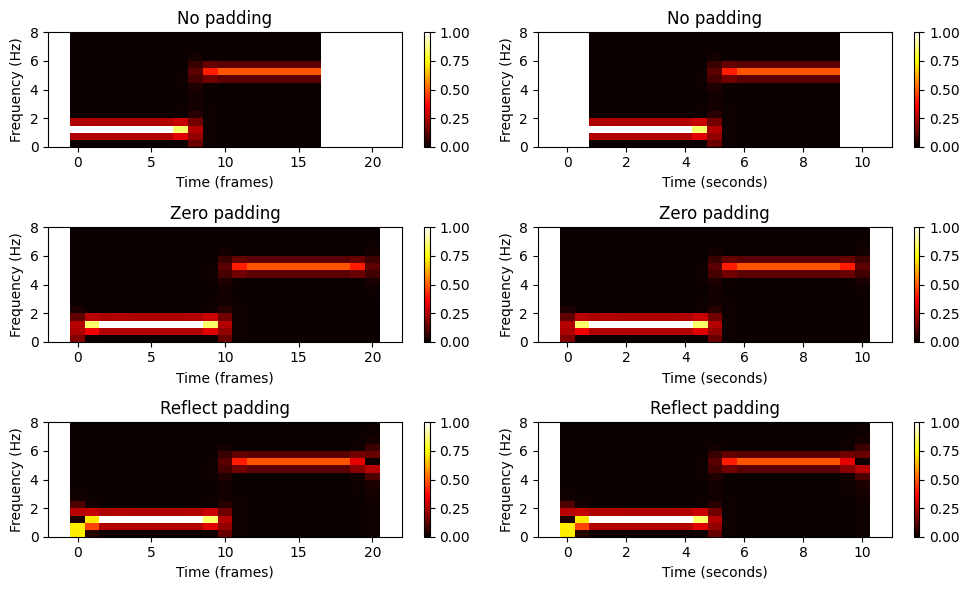

In [21]:
N = 512
H = 128
xlim_frame = [-2, 22]
xlim_sec = [-1, 11]
ylim_hz = [0, 8]

plt.figure(figsize=(10, 6))

# No padding
Y = compute_stft(x, Fs, N, H, pad_mode=None, center=False)
plt.subplot(3, 2, 1)
plot_stft(Y, Fs, N, H, xlim=xlim_frame, ylim=ylim_hz, title='No padding')

plt.subplot(3, 2, 2)
plot_stft(Y, Fs, N, H, time_offset=N / (2 * Fs), time_unit='sec', xlim=xlim_sec, ylim=ylim_hz, title='No padding')

# Zero padding
Y = compute_stft(x, Fs, N, H, pad_mode='constant', center=True)
plt.subplot(3, 2, 3)
plot_stft(Y, Fs, N, H, xlim=xlim_frame, ylim=ylim_hz, title='Zero padding')

plt.subplot(3, 2, 4)
plot_stft(Y, Fs, N, H, time_unit='sec', xlim=xlim_sec, ylim=ylim_hz, title='Zero padding')

# Reflect padding
Y = compute_stft(x, Fs, N, H, pad_mode='reflect', center=True)
plt.subplot(3, 2, 5)
plot_stft(Y, Fs, N, H, xlim=xlim_frame, ylim=ylim_hz, title='Reflect padding')

plt.subplot(3, 2, 6)
time_sec = np.arange(Y.shape[1]) * (H / Fs) 
plot_stft(Y, Fs, N, H, time_unit='sec', xlim=xlim_sec, ylim=ylim_hz, title='Reflect padding')

plt.tight_layout()

# 예시

-  피아노로 연주되는 C장조 음계를 보자. 

- 스펙트로그램은 시간 경과에 따라 연주된 음의 주파수 정보를 보여준다. 각 음표에 대해 서로 위에 쌓인 수평선을 관찰할 수 있다. 이 같은 간격의 선은 음의 기본 주파수의 정수배인 부분에 해당한다. 더 높은 부분은 더 적은 신호 에너지를 포함한다. 또한 시간 경과에 따른 각 음의 감소는 수평선의 페이드 아웃으로 반영된다.

In [22]:
ipd.Audio("../audio/piano_c_scale.wav")

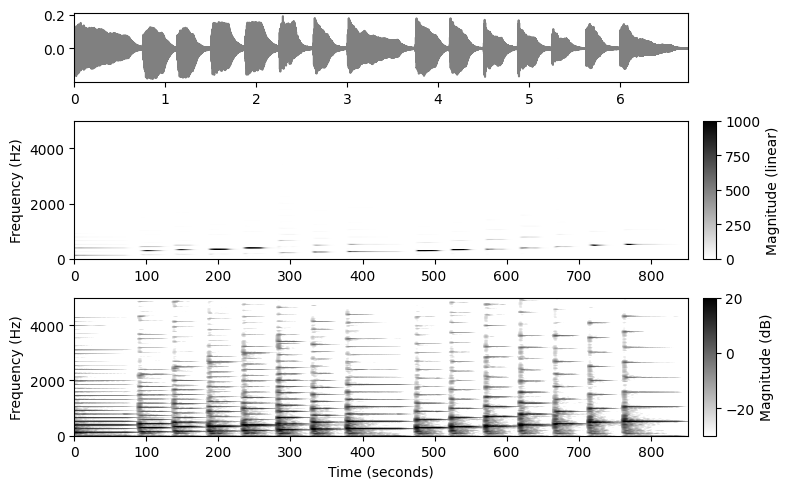

In [23]:
fn_wav = "../audio/piano_c_scale.wav"
x, Fs = librosa.load(fn_wav)

H = 1024 # hop size
N = 2048
w = np.hanning(N)
X = stft_basic(x, w, H=8)
Y = np.abs(X) ** 2
eps = np.finfo(float).eps
Y_db = 10 * np.log10(Y + eps)

T_coef = np.arange(X.shape[1]) * H / Fs
F_coef = np.arange(X.shape[0]) * Fs / N


fig = plt.figure(figsize=(8, 5))

gs = matplotlib.gridspec.GridSpec(3, 2, height_ratios=[1, 2, 2], width_ratios=[100, 2])
ax1, ax2, ax3, ax4, ax5, ax6 = [plt.subplot(gs[i]) for i in range(6)]

t = np.arange(len(x)) / Fs
ax1.plot(t, x, c='gray')
ax1.set_xlim([min(t), max(t)])

ax2.set_visible(False)

left = min(T_coef)
right = max(T_coef) + N / Fs
lower = min(F_coef)
upper = max(F_coef)

im1 = ax3.imshow(Y, origin='lower', aspect='auto', cmap='gray_r', 
                 extent=[left, right, lower, upper])
im1.set_clim([0, 1000])
ax3.set_ylim([0, 5000])
ax3.set_ylabel('Frequency (Hz)')
cbar = fig.colorbar(im1, cax=ax4)
ax4.set_ylabel('Magnitude (linear)', rotation=90)

im2 = ax5.imshow(Y_db, origin='lower', aspect='auto', cmap='gray_r', 
                 extent=[left, right, lower, upper])
im2.set_clim([-30, 20])
ax5.set_ylim([0, 5000])
ax5.set_xlabel('Time (seconds)')
ax5.set_ylabel('Frequency (Hz)')
cbar = fig.colorbar(im2, cax=ax6)
ax6.set_ylabel('Magnitude (dB)', rotation=90)

plt.tight_layout()

---

출처: 

- https://www.audiolabs-erlangen.de/resources/MIR/FMP/C2/C2.html
---

[구글 Colab 링크](https://colab.research.google.com/github/jo-cho/mir_kr/blob/main/Notebooks/3.%20Fourier%20Analysis%20of%20Signals/3.3.Short-term_Fourier_Transform_1.ipynb)